# **Import Necessary Libraries**

In [28]:
import os
import cv2
import random
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, zipfile, shutil, random
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten

# **Data Load**

In [3]:
zip_path = "/content/archive_kidneyston.zip"
extract_path = "/content/archive_kidneystone"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

inner_items = os.listdir(extract_path)
if len(inner_items) == 1 and os.path.isdir(os.path.join(extract_path, inner_items[0])):
    original_data = os.path.join(extract_path, inner_items[0])
else:
    original_data = extract_path

print("Dataset located at:", original_data)
print("Classes found:", os.listdir(original_data))

Dataset located at: /content/archive_kidneystone
Classes found: ['Normal', 'stone']


# **Visualisation of Normal and Stone Classes**

Detected classes: ['Normal', 'stone']


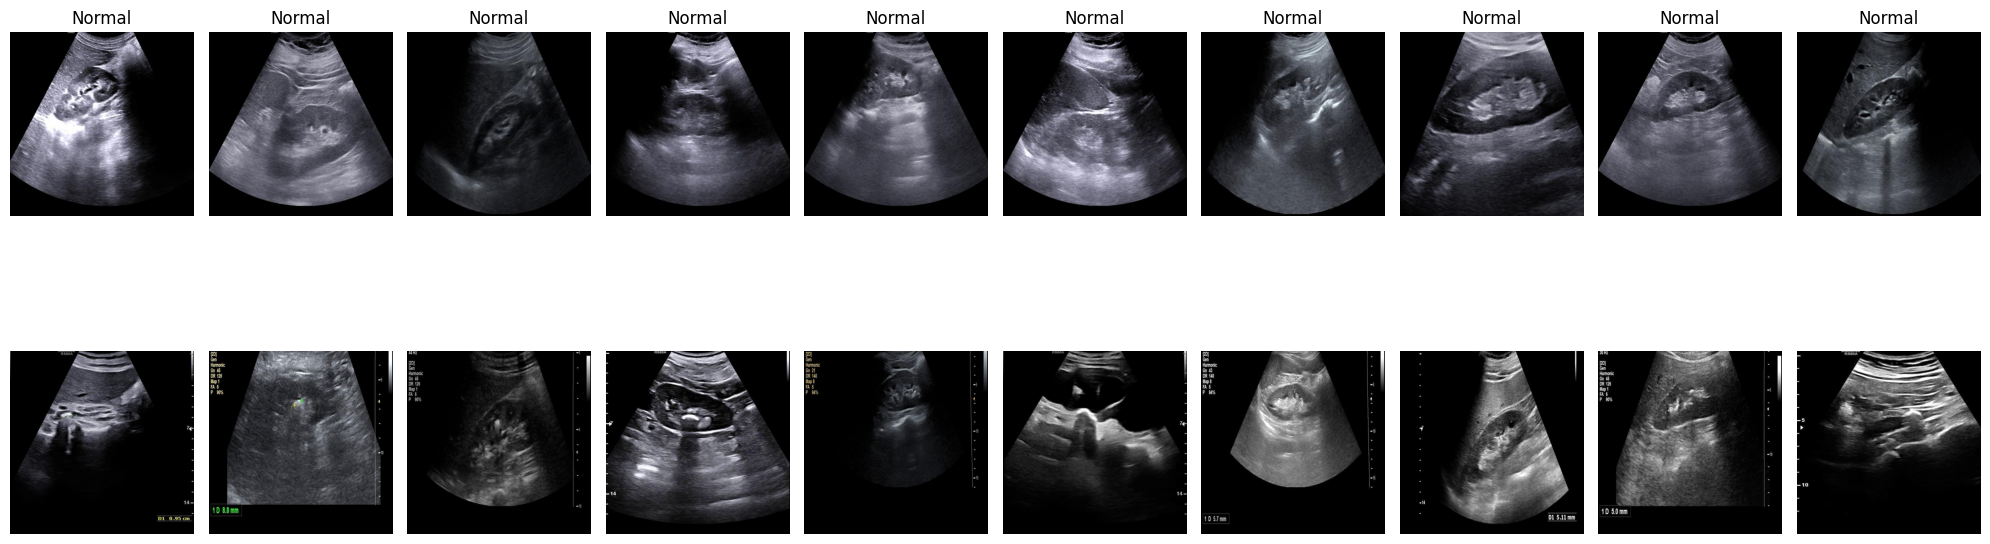

In [4]:
classes = sorted([d for d in os.listdir(original_data) if os.path.isdir(os.path.join(original_data, d))])
print("Detected classes:", classes)

plt.figure(figsize=(20, 8))

index = 1
for cls in classes:
    cls_path = os.path.join(original_data, cls)
    images = os.listdir(cls_path)[:10]

    for img_name in images:
        img_path = os.path.join(cls_path, img_name)
        img = mpimg.imread(img_path)

        plt.subplot(len(classes), 10, index)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if index <= 10:
            plt.title(cls)
        index += 1

plt.tight_layout()
plt.show()

# **Train Test Validation Function Creation**


In [15]:
def create_split_folders(input_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    classes = os.listdir(input_dir)
    for cls in classes:
        cls_path = os.path.join(input_dir, cls)
        images = os.listdir(cls_path)
        random.shuffle(images)
        total = len(images)

        train_end = int(train_ratio * total)
        val_end = int((train_ratio + val_ratio) * total)

        splits = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split, split_images in splits.items():
            split_dir = os.path.join(output_dir, split, cls)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                shutil.copy(os.path.join(cls_path, img), split_dir)

split_data_path = "/content/kidney_data_split"
create_split_folders(original_data, split_data_path)

train_dir = os.path.join(split_data_path, 'train')
val_dir = os.path.join(split_data_path, 'val')
test_dir = os.path.join(split_data_path, 'test')

#  **Data Preprocessing & Augmentation**

In [16]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 6590 images belonging to 2 classes.
Found 1412 images belonging to 2 classes.
Found 1414 images belonging to 2 classes.


# **EfficientNet Model Building**

In [17]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

for layer in base_model.layers[-20:]:
    layer.trainable = True

model = Sequential([
    base_model,
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 256)      │     2,949,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,493,156 (28.58 MB)

 Trainable params: 7,450,365 (28.42 MB)

 Non-trainable params: 42,791 (167.16 KB)

# **EfficientNet Model Training**

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_kidney_model.h5', save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.5289 - loss: 0.8870

206/206 ━━━━━━━━━━━━━━━━━━━━ 233s 692ms/step - accuracy: 0.5291 - loss: 0.8865 - val_accuracy: 0.5283 - val_loss: 0.7111
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7014 - loss: 0.5897

206/206 ━━━━━━━━━━━━━━━━━━━━ 76s 367ms/step - accuracy: 0.7015 - loss: 0.5895 - val_accuracy: 0.6388 - val_loss: 0.5814
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8118 - loss: 0.4323

206/206 ━━━━━━━━━━━━━━━━━━━━ 75s 362ms/step - accuracy: 0.8119 - loss: 0.4322 - val_accuracy: 0.8180 - val_loss: 0.4253
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.8772 - loss: 0.3093

206/206 ━━━━━━━━━━━━━━━━━━━━ 75s 366ms/step - accuracy: 0.8773 - loss: 0.3092 - val_accuracy: 0.8229 - val_loss: 0.3847
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9113 - loss: 0.2356

206/206 ━━━━━━━━━━━━━━━━━━━━ 75s 365ms/step - accuracy: 0.9114 - loss: 0.2355 - val_accuracy: 0.8414 - val_loss: 0.3573
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9263 - loss: 0.2019

206/206 ━━━━━━━━━━━━━━━━━━━━ 75s 364ms/step - accuracy: 0.9264 - loss: 0.2019 - val_accuracy: 0.8683 - val_loss: 0.3391
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9468 - loss: 0.1552

206/206 ━━━━━━━━━━━━━━━━━━━━ 75s 366ms/step - accuracy: 0.9468 - loss: 0.1551 - val_accuracy: 0.8824 - val_loss: 0.2751
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9520 - loss: 0.1367

206/206 ━━━━━━━━━━━━━━━━━━━━ 75s 365ms/step - accuracy: 0.9520 - loss: 0.1367 - val_accuracy: 0.9681 - val_loss: 0.0974
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 75s 366ms/step - accuracy: 0.9595 - loss: 0.1297 - val_accuracy: 0.9603 - val_loss: 0.1302
Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 75s 363ms/step - accuracy: 0.9610 - loss: 0.1113 - val_accuracy: 0.6147 - val_loss: 0.6558


# **EfficientNet Model Evaluation**

45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step - accuracy: 0.9623 - loss: 0.1245
Test Accuracy: 97.52%
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step
Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.96      0.97       663
       Stone       0.97      0.99      0.98       751

    accuracy                           0.98      1414
   macro avg       0.98      0.97      0.98      1414
weighted avg       0.98      0.98      0.98      1414



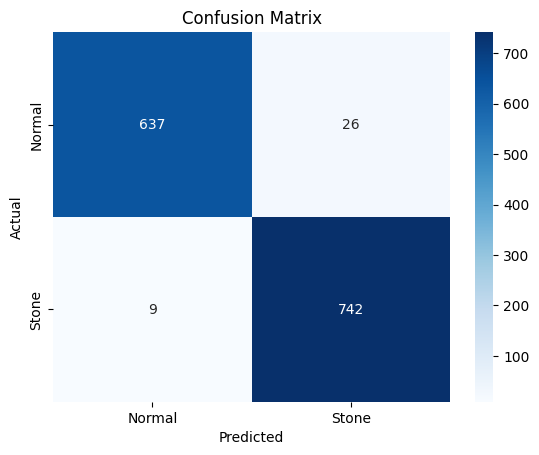

In [22]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Normal', 'Stone']))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal', 'Stone'],
            yticklabels=['Normal', 'Stone'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **ResNet50 Model Building**

In [20]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

for layer in resnet_base.layers[:-20]:
    layer.trainable = False
for layer in resnet_base.layers[-20:]:
    layer.trainable = True

resnet_model = Sequential([
    resnet_base,
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

resnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 256)      │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,800,769 (109.87 MB)

 Trainable params: 14,143,617 (53.95 MB)

 Non-trainable params: 14,657,152 (55.91 MB)

# **ResNet50 Model Training**

In [21]:
resnet_checkpoint = ModelCheckpoint('best_resnet_kidney_model.h5', save_best_only=True)
resnet_early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[resnet_early_stop, resnet_checkpoint]
)

Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5986 - loss: 0.7367

206/206 ━━━━━━━━━━━━━━━━━━━━ 109s 432ms/step - accuracy: 0.5990 - loss: 0.7362 - val_accuracy: 0.5269 - val_loss: 0.6882
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7883 - loss: 0.4393

206/206 ━━━━━━━━━━━━━━━━━━━━ 75s 365ms/step - accuracy: 0.7884 - loss: 0.4391 - val_accuracy: 0.9143 - val_loss: 0.2800
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.8657 - loss: 0.3272

206/206 ━━━━━━━━━━━━━━━━━━━━ 75s 366ms/step - accuracy: 0.8658 - loss: 0.3272 - val_accuracy: 0.9745 - val_loss: 0.0876
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8825 - loss: 0.2884

206/206 ━━━━━━━━━━━━━━━━━━━━ 75s 365ms/step - accuracy: 0.8825 - loss: 0.2884 - val_accuracy: 0.9851 - val_loss: 0.0673
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 74s 361ms/step - accuracy: 0.8910 - loss: 0.2712 - val_accuracy: 0.9880 - val_loss: 0.0882
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9080 - loss: 0.2401

206/206 ━━━━━━━━━━━━━━━━━━━━ 75s 365ms/step - accuracy: 0.9080 - loss: 0.2401 - val_accuracy: 0.9816 - val_loss: 0.0592
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9007 - loss: 0.2459

206/206 ━━━━━━━━━━━━━━━━━━━━ 76s 369ms/step - accuracy: 0.9007 - loss: 0.2459 - val_accuracy: 0.9880 - val_loss: 0.0475
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 75s 362ms/step - accuracy: 0.9026 - loss: 0.2397 - val_accuracy: 0.9908 - val_loss: 0.0532
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9173 - loss: 0.2196

206/206 ━━━━━━━━━━━━━━━━━━━━ 76s 368ms/step - accuracy: 0.9173 - loss: 0.2195 - val_accuracy: 0.9943 - val_loss: 0.0383
Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 74s 360ms/step - accuracy: 0.9297 - loss: 0.1929 - val_accuracy: 0.8839 - val_loss: 0.2550


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9848 - loss: 0.0667
ResNet50 Test Accuracy: 98.80%
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step
ResNet50 Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.98      0.99       663
       Stone       0.98      0.99      0.99       751

    accuracy                           0.99      1414
   macro avg       0.99      0.99      0.99      1414
weighted avg       0.99      0.99      0.99      1414



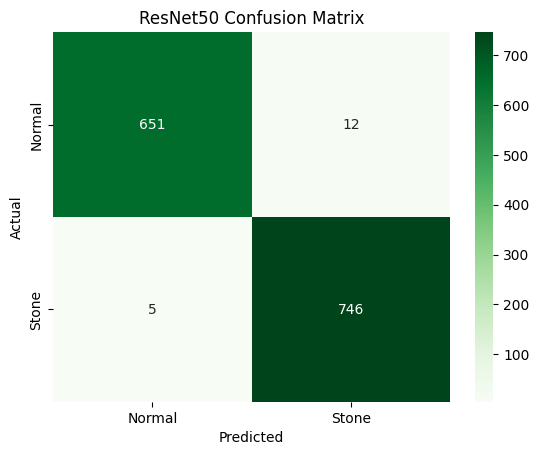

In [23]:
loss_rn, acc_rn = resnet_model.evaluate(test_generator)
print(f"ResNet50 Test Accuracy: {acc_rn * 100:.2f}%")

y_pred_rn = (resnet_model.predict(test_generator) > 0.5).astype("int32")
y_true_rn = test_generator.classes

print("ResNet50 Classification Report:\n", classification_report(y_true_rn, y_pred_rn, target_names=['Normal', 'Stone']))

cm_rn = confusion_matrix(y_true_rn, y_pred_rn)
sns.heatmap(cm_rn, annot=True, fmt="d", cmap="Greens",
            xticklabels=['Normal', 'Stone'],
            yticklabels=['Normal', 'Stone'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ResNet50 Confusion Matrix")
plt.show()

# **EfficientNet AUC-ROC Curve Visualisation**

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step


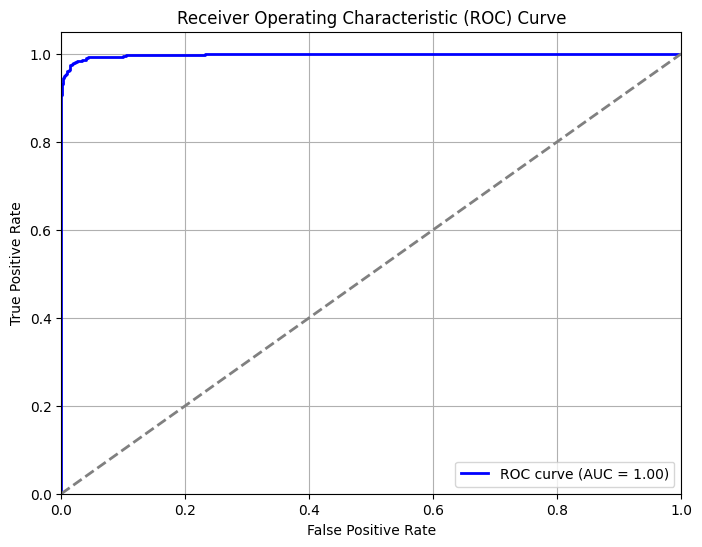

In [24]:
y_prob = model.predict(test_generator)

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **ResNet50 AUC-ROC Curve Visualisation**

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step


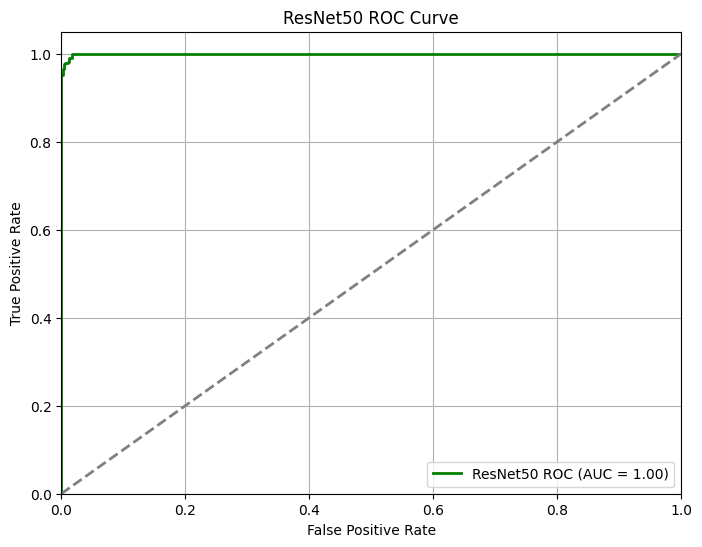

In [25]:
y_prob_rn = resnet_model.predict(test_generator)

fpr_rn, tpr_rn, _ = roc_curve(y_true_rn, y_prob_rn)
roc_auc_rn = auc(fpr_rn, tpr_rn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rn, tpr_rn, color='green', lw=2, label='ResNet50 ROC (AUC = {:.2f})'.format(roc_auc_rn))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet50 ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **EfficientNet Training and Loss Curves Visualisation**

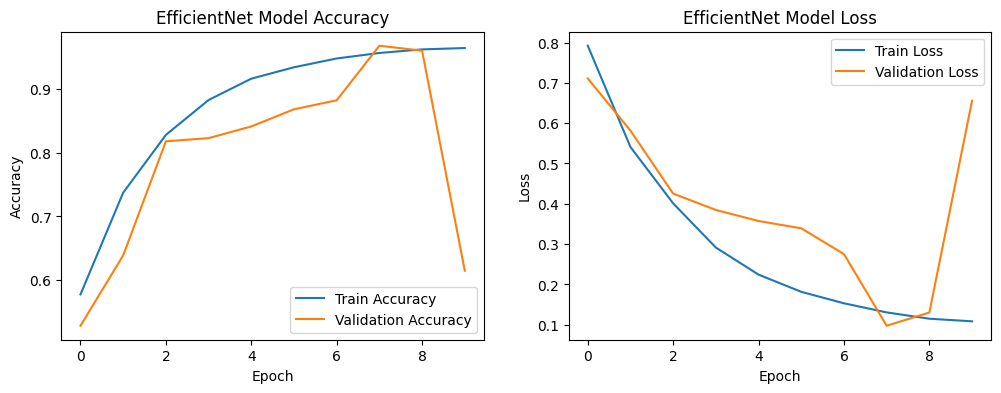

In [26]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('EfficientNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **ResNet50 Training and Loss Curves Visualisation**

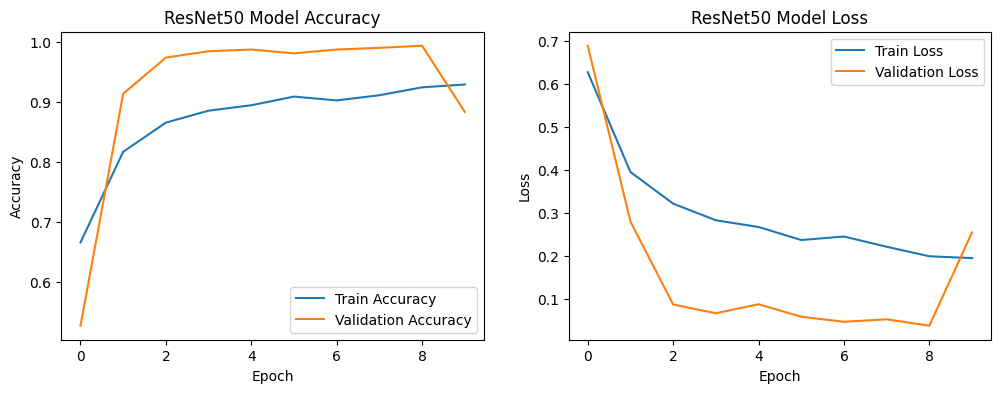

In [34]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], label='Train Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **Model Comparison Dataframe**

In [30]:
y_pred_en = (model.predict(test_generator) > 0.5).astype("int32")
y_prob_en = model.predict(test_generator)
y_true = test_generator.classes

y_pred_rn = (resnet_model.predict(test_generator) > 0.5).astype("int32")
y_prob_rn = resnet_model.predict(test_generator)
y_true_rn = test_generator.classes

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step


In [32]:
report_en = classification_report(y_true, y_pred_en, output_dict=True)
cm_en = confusion_matrix(y_true, y_pred_en)

report_rn = classification_report(y_true_rn, y_pred_rn, output_dict=True)
cm_rn = confusion_matrix(y_true_rn, y_pred_rn)

In [35]:
comparison_df = pd.DataFrame({
    'Model': ['EfficientNetB0', 'ResNet50'],
    'Test Accuracy': [accuracy * 100, acc_rn * 100],
    'Precision (Stone)': [report_en['1']['precision'], report_rn['1']['precision']],
    'Recall (Stone)': [report_en['1']['recall'], report_rn['1']['recall']],
    'F1 Score (Stone)': [report_en['1']['f1-score'], report_rn['1']['f1-score']],
    'Confusion Matrix': [cm_en.tolist(), cm_rn.tolist()]
})

comparison_df.round(2)

,Model,Test Accuracy,Precision (Stone),Recall (Stone),F1 Score (Stone),Confusion Matrix
0,EfficientNetB0,97.52,0.97,0.99,0.98,"[[637, 26], [9, 742]]"
1,ResNet50,98.80,0.98,0.99,0.99,"[[651, 12], [5, 746]]"
